# Seq2Seq English-Spanish Translation
### LSTM Encoder-Decoder | No Attention | Bahdanau | Luong

In [1]:
# Cell 1: Install dependencies
!pip install torch sacrebleu matplotlib pandas tqdm --quiet

In [2]:
# Cell 2: Imports and global config
import re, math, time, random, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sacrebleu.metrics import BLEU
from tqdm import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [3]:
# Cell 3: Load and preprocess data
# Place spa.txt in the same folder as this notebook
DATA_PATH = 'spa.txt'

def normalize(text):
    text = text.lower().strip()
    text = ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn')
    text = re.sub(r'([.!?])', r' \1', text)
    text = re.sub(r'[^a-zA-Z.!?]+', r' ', text)
    return text.strip()

def load_pairs(path, max_pairs=5000):
    pairs = []
    with open(path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                pairs.append((normalize(parts[0]), normalize(parts[1])))
    random.shuffle(pairs)
    return pairs[:max_pairs]

pairs = load_pairs(DATA_PATH)
print(f'Loaded {len(pairs)} pairs | Sample: {pairs[0]}')

Loaded 5000 pairs | Sample: ('how long have you been studying hungarian ?', 'cuanto tiempo has estado estudiando hungaro ?')


In [4]:
# Cell 4: Vocabulary
class Vocabulary:
    PAD, SOS, EOS, UNK = 0, 1, 2, 3
    def __init__(self, name):
        self.name = name
        self.t2i = {'<PAD>':0,'<SOS>':1,'<EOS>':2,'<UNK>':3}
        self.i2t = {v:k for k,v in self.t2i.items()}
        self.n_words = 4

    def add_sentence(self, sentence):
        for t in sentence.split():
            if t not in self.t2i:
                self.t2i[t] = self.n_words
                self.i2t[self.n_words] = t
                self.n_words += 1

    def encode(self, sentence):
        return [self.t2i.get(t, self.UNK) for t in sentence.split()] + [self.EOS]

    def decode(self, indices):
        out = []
        for i in indices:
            if i == self.EOS: break
            if i not in (self.PAD, self.SOS): out.append(self.i2t.get(i,'<UNK>'))
        return ' '.join(out)

src_vocab, tgt_vocab = Vocabulary('en'), Vocabulary('es')
for eng, spa in pairs:
    src_vocab.add_sentence(eng)
    tgt_vocab.add_sentence(spa)
print(f'EN vocab: {src_vocab.n_words} | ES vocab: {tgt_vocab.n_words}')

EN vocab: 3434 | ES vocab: 5025


In [5]:
# Cell 5: Dataset and DataLoader
class TranslationDataset(Dataset):
    def __init__(self, pairs, sv, tv):
        self.pairs, self.sv, self.tv = pairs, sv, tv
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        e, s = self.pairs[i]
        return (torch.tensor(self.sv.encode(e), dtype=torch.long),
                torch.tensor([self.tv.SOS] + self.tv.encode(s), dtype=torch.long))

def collate_fn(batch):
    src, tgt = zip(*batch)
    src_lens = torch.tensor([len(s) for s in src])
    src_pad  = nn.utils.rnn.pad_sequence(src, batch_first=True, padding_value=0)
    tgt_pad  = nn.utils.rnn.pad_sequence(tgt, batch_first=True, padding_value=0)
    return src_pad, tgt_pad, src_lens

n = len(pairs)
train_p, val_p, test_p = pairs[:int(.8*n)], pairs[int(.8*n):int(.9*n)], pairs[int(.9*n):]
BATCH = 64
train_dl = DataLoader(TranslationDataset(train_p, src_vocab, tgt_vocab), BATCH, shuffle=True,  collate_fn=collate_fn)
val_dl   = DataLoader(TranslationDataset(val_p,   src_vocab, tgt_vocab), BATCH, shuffle=False, collate_fn=collate_fn)
test_dl  = DataLoader(TranslationDataset(test_p,  src_vocab, tgt_vocab), 1,     shuffle=False, collate_fn=collate_fn)
print(f'Train:{len(train_p)} | Val:{len(val_p)} | Test:{len(test_p)}')

Train:4000 | Val:500 | Test:500


In [6]:
# Cell 6: Shared Encoder (bidirectional LSTM)
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb, hid, layers, drop):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=0)
        self.rnn = nn.LSTM(emb, hid, layers, batch_first=True,
                           dropout=drop if layers>1 else 0, bidirectional=True)
        self.fc_h = nn.Linear(hid*2, hid)
        self.fc_c = nn.Linear(hid*2, hid)
        self.drop = nn.Dropout(drop)

    def forward(self, src, lens):
        x = self.drop(self.emb(src))
        packed = pack_padded_sequence(x, lens.cpu(), batch_first=True, enforce_sorted=False)
        out, (h, c) = self.rnn(packed)
        out, _ = pad_packed_sequence(out, batch_first=True)
        h = torch.tanh(self.fc_h(torch.cat([h[-2], h[-1]], 1))).unsqueeze(0)
        c = torch.tanh(self.fc_c(torch.cat([c[-2], c[-1]], 1))).unsqueeze(0)
        return out, h, c

In [7]:
# Cell 7: Decoder without attention
class DecoderNoAttn(nn.Module):
    def __init__(self, vocab_size, emb, hid, drop):
        super().__init__()
        self.emb  = nn.Embedding(vocab_size, emb, padding_idx=0)
        self.rnn  = nn.LSTM(emb, hid, 1, batch_first=True)
        self.fc   = nn.Linear(hid, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, token, h, c, enc_out=None, mask=None):
        x = self.drop(self.emb(token.unsqueeze(1)))        # (B,1,E)
        out, (h, c) = self.rnn(x, (h, c))
        return self.fc(out.squeeze(1)), h, c, None


# Cell 7b: Bahdanau (additive) attention
class BahdanauAttention(nn.Module):
    def __init__(self, hid, enc_dim):
        super().__init__()
        self.W1 = nn.Linear(hid, hid, bias=False)
        self.W2 = nn.Linear(enc_dim, hid, bias=False)
        self.V  = nn.Linear(hid, 1, bias=False)

    def forward(self, dec_h, enc_out, mask=None):
        energy = self.V(torch.tanh(self.W1(dec_h).unsqueeze(1) + self.W2(enc_out))).squeeze(2)
        if mask is not None: energy = energy.masked_fill(~mask, -1e10)
        w = F.softmax(energy, dim=1)
        return torch.bmm(w.unsqueeze(1), enc_out).squeeze(1), w


# Cell 7c: Luong (multiplicative) attention
class LuongAttention(nn.Module):
    def __init__(self, hid, enc_dim):
        super().__init__()
        self.W = nn.Linear(enc_dim, hid, bias=False)

    def forward(self, dec_h, enc_out, mask=None):
        energy = torch.bmm(self.W(enc_out), dec_h.unsqueeze(2)).squeeze(2)
        if mask is not None: energy = energy.masked_fill(~mask, -1e10)
        w = F.softmax(energy, dim=1)
        return torch.bmm(w.unsqueeze(1), enc_out).squeeze(1), w


# Cell 7d: Decoder with attention
class DecoderWithAttn(nn.Module):
    def __init__(self, vocab_size, emb, hid, enc_dim, drop, attn):
        super().__init__()
        self.attn = attn
        self.emb  = nn.Embedding(vocab_size, emb, padding_idx=0)
        self.rnn  = nn.LSTM(emb + enc_dim, hid, 1, batch_first=True)
        self.fc   = nn.Linear(hid + enc_dim, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, token, h, c, enc_out, mask=None):
        x = self.drop(self.emb(token.unsqueeze(1)))         # (B,1,E)
        ctx, w = self.attn(h[-1], enc_out, mask)
        rnn_in = torch.cat([x, ctx.unsqueeze(1)], dim=2)    # (B,1,E+enc_dim)
        out, (h, c) = self.rnn(rnn_in, (h, c))
        pred = self.fc(torch.cat([out.squeeze(1), ctx], dim=1))
        return pred, h, c, w

In [8]:
# Cell 8: Seq2Seq wrapper with teacher forcing
class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, tgt_vsz, device):
        super().__init__()
        self.enc, self.dec, self.tgt_vsz, self.device = enc, dec, tgt_vsz, device

    def forward(self, src, src_lens, tgt, tf_ratio=0.5):
        B, T = tgt.shape
        preds = torch.zeros(B, T, self.tgt_vsz).to(self.device)
        enc_out, h, c = self.enc(src, src_lens)
        mask = (src != 0)                      # True where not padding
        inp  = tgt[:, 0]                        # <SOS>
        for t in range(1, T):
            pred, h, c, _ = self.dec(inp, h, c, enc_out, mask)
            preds[:, t] = pred
            inp = tgt[:, t] if random.random() < tf_ratio else pred.argmax(1)
        return preds

In [9]:
# Cell 9: Train / Evaluate helpers
def train_epoch(model, loader, opt, crit):
    model.train(); total = 0
    for src, tgt, lens in tqdm(loader, leave=False):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        opt.zero_grad()
        out  = model(src, lens, tgt)
        loss = crit(out[:,1:].reshape(-1, out.shape[2]), tgt[:,1:].reshape(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); total += loss.item()
    return total / len(loader)

@torch.no_grad()
def evaluate(model, loader, crit):
    model.eval(); total = 0
    for src, tgt, lens in loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        out  = model(src, lens, tgt, tf_ratio=0.0)
        loss = crit(out[:,1:].reshape(-1, out.shape[2]), tgt[:,1:].reshape(-1))
        total += loss.item()
    return total / len(loader)

@torch.no_grad()
def compute_bleu(model, pairs, max_len=50):
    model.eval(); hyps, refs = [], []
    for eng, spa in pairs:
        ids  = torch.tensor(src_vocab.encode(eng)).unsqueeze(0).to(DEVICE)
        lens = torch.tensor([ids.shape[1]])
        enc_out, h, c = model.enc(ids, lens)
        mask = (ids != 0)
        tok  = torch.tensor([tgt_vocab.SOS]).to(DEVICE)
        out  = []
        for _ in range(max_len):
            pred, h, c, _ = model.dec(tok, h, c, enc_out, mask)
            tok = pred.argmax(1)
            if tok.item() == tgt_vocab.EOS: break
            out.append(tok.item())
        hyps.append(tgt_vocab.decode(out)); refs.append([spa])
    return BLEU().corpus_score(hyps, refs).score, hyps

In [10]:
# Cell 10: Hyperparameters
EMB, HID, LAYERS, DROP = 256, 512, 2, 0.3
ENC_DIM = HID * 2          # bidirectional encoder output size
EPOCHS, LR = 5, 3e-4
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [11]:
# Cell 11: Build and train Model 1 - No Attention
enc1  = Encoder(src_vocab.n_words, EMB, HID, LAYERS, DROP).to(DEVICE)
dec1  = DecoderNoAttn(tgt_vocab.n_words, EMB, HID, DROP).to(DEVICE)
model_noa = Seq2Seq(enc1, dec1, tgt_vocab.n_words, DEVICE).to(DEVICE)
opt1  = torch.optim.Adam(model_noa.parameters(), lr=LR)

tl_noa, vl_noa, best = [], [], float('inf')
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tl = train_epoch(model_noa, train_dl, opt1, criterion)
    vl = evaluate(model_noa, val_dl, criterion)
    tl_noa.append(tl); vl_noa.append(vl)
    if vl < best: best = vl; torch.save(model_noa.state_dict(), 'noa_best.pt')
    print(f'[NoAttn] Ep {ep:02d} | TrLoss {tl:.4f} | ValLoss {vl:.4f} | PPL {math.exp(vl):.2f} | {time.time()-t0:.1f}s')

[NoAttn] Ep 01 | TrLoss 6.3787 | ValLoss 5.7173 | PPL 304.10 | 62.3s


[NoAttn] Ep 02 | TrLoss 5.3376 | ValLoss 5.7081 | PPL 301.29 | 62.2s


[NoAttn] Ep 03 | TrLoss 5.2552 | ValLoss 5.7531 | PPL 315.17 | 60.8s


[NoAttn] Ep 04 | TrLoss 5.1855 | ValLoss 5.7661 | PPL 319.30 | 60.7s


[NoAttn] Ep 05 | TrLoss 5.1474 | ValLoss 5.8098 | PPL 333.57 | 60.8s


In [12]:
# Cell 12: Build and train Model 2 - Bahdanau Attention
enc2  = Encoder(src_vocab.n_words, EMB, HID, LAYERS, DROP).to(DEVICE)
attn2 = BahdanauAttention(HID, ENC_DIM).to(DEVICE)
dec2  = DecoderWithAttn(tgt_vocab.n_words, EMB, HID, ENC_DIM, DROP, attn2).to(DEVICE)
model_bah = Seq2Seq(enc2, dec2, tgt_vocab.n_words, DEVICE).to(DEVICE)
opt2  = torch.optim.Adam(model_bah.parameters(), lr=LR)

tl_bah, vl_bah, best = [], [], float('inf')
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tl = train_epoch(model_bah, train_dl, opt2, criterion)
    vl = evaluate(model_bah, val_dl, criterion)
    tl_bah.append(tl); vl_bah.append(vl)
    if vl < best: best = vl; torch.save(model_bah.state_dict(), 'bah_best.pt')
    print(f'[Bahdanau] Ep {ep:02d} | TrLoss {tl:.4f} | ValLoss {vl:.4f} | PPL {math.exp(vl):.2f} | {time.time()-t0:.1f}s')

[Bahdanau] Ep 01 | TrLoss 6.1522 | ValLoss 5.6355 | PPL 280.21 | 145.1s


[Bahdanau] Ep 02 | TrLoss 5.1590 | ValLoss 5.3802 | PPL 217.07 | 133.7s


[Bahdanau] Ep 03 | TrLoss 4.8406 | ValLoss 5.3627 | PPL 213.30 | 134.6s


[Bahdanau] Ep 04 | TrLoss 4.5797 | ValLoss 5.2205 | PPL 185.03 | 136.0s


[Bahdanau] Ep 05 | TrLoss 4.2945 | ValLoss 5.1297 | PPL 168.96 | 131.2s


In [13]:
# Cell 13: Build and train Model 3 - Luong Attention
enc3  = Encoder(src_vocab.n_words, EMB, HID, LAYERS, DROP).to(DEVICE)
attn3 = LuongAttention(HID, ENC_DIM).to(DEVICE)
dec3  = DecoderWithAttn(tgt_vocab.n_words, EMB, HID, ENC_DIM, DROP, attn3).to(DEVICE)
model_luo = Seq2Seq(enc3, dec3, tgt_vocab.n_words, DEVICE).to(DEVICE)
opt3  = torch.optim.Adam(model_luo.parameters(), lr=LR)

tl_luo, vl_luo, best = [], [], float('inf')
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tl = train_epoch(model_luo, train_dl, opt3, criterion)
    vl = evaluate(model_luo, val_dl, criterion)
    tl_luo.append(tl); vl_luo.append(vl)
    if vl < best: best = vl; torch.save(model_luo.state_dict(), 'luo_best.pt')
    print(f'[Luong] Ep {ep:02d} | TrLoss {tl:.4f} | ValLoss {vl:.4f} | PPL {math.exp(vl):.2f} | {time.time()-t0:.1f}s')

[Luong] Ep 01 | TrLoss 6.1250 | ValLoss 5.6323 | PPL 279.32 | 126.6s


[Luong] Ep 02 | TrLoss 5.2015 | ValLoss 5.4599 | PPL 235.08 | 127.4s


[Luong] Ep 03 | TrLoss 4.8907 | ValLoss 5.3323 | PPL 206.91 | 129.4s


[Luong] Ep 04 | TrLoss 4.6470 | ValLoss 5.2593 | PPL 192.34 | 128.8s


[Luong] Ep 05 | TrLoss 4.3712 | ValLoss 5.2224 | PPL 185.37 | 130.9s


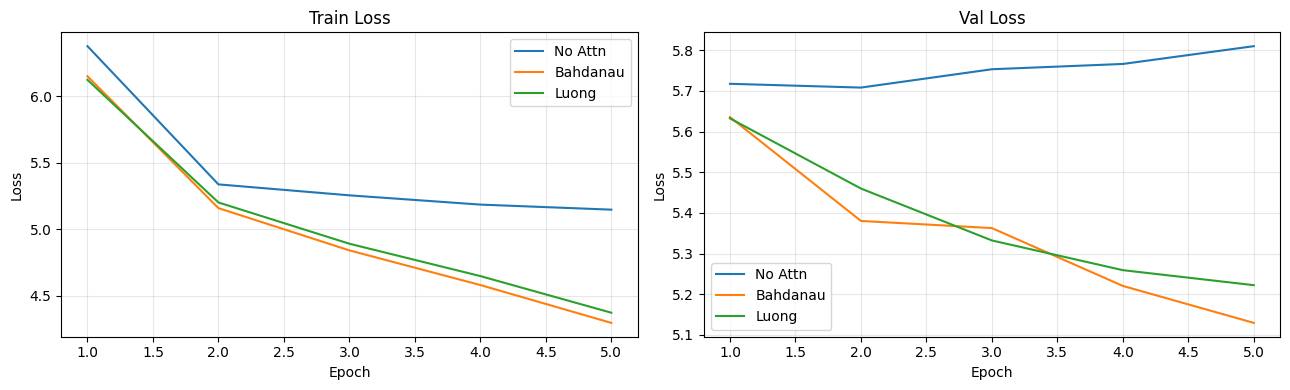

In [14]:
# Cell 14: Loss curves
ep = range(1, EPOCHS+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
for tl, label in [(tl_noa,'No Attn'),(tl_bah,'Bahdanau'),(tl_luo,'Luong')]:
    ax1.plot(ep, tl, label=label)
for vl, label in [(vl_noa,'No Attn'),(vl_bah,'Bahdanau'),(vl_luo,'Luong')]:
    ax2.plot(ep, vl, label=label)
for ax, title in [(ax1,'Train Loss'),(ax2,'Val Loss')]:
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.set_title(title); ax.legend(); ax.grid(alpha=.3)
plt.tight_layout(); plt.savefig('loss_curves.png', dpi=150); plt.show()

In [15]:
# Cell 15: BLEU scores on test set (loads best checkpoints)
model_noa.load_state_dict(torch.load('noa_best.pt', map_location=DEVICE))
model_bah.load_state_dict(torch.load('bah_best.pt', map_location=DEVICE))
model_luo.load_state_dict(torch.load('luo_best.pt', map_location=DEVICE))

bleu_noa, _ = compute_bleu(model_noa, test_p)
bleu_bah, _ = compute_bleu(model_bah, test_p)
bleu_luo, _ = compute_bleu(model_luo, test_p)

print(f'BLEU | No Attn: {bleu_noa:.2f} | Bahdanau: {bleu_bah:.2f} | Luong: {bleu_luo:.2f}')

BLEU | No Attn: 37.99 | Bahdanau: 22.75 | Luong: 21.74


In [16]:
# Cell 16: Sample translations
@torch.no_grad()
def translate(model, sentence, max_len=50):
    model.eval()
    ids  = torch.tensor(src_vocab.encode(normalize(sentence))).unsqueeze(0).to(DEVICE)
    lens = torch.tensor([ids.shape[1]])
    enc_out, h, c = model.enc(ids, lens)
    mask = (ids != 0)
    tok  = torch.tensor([tgt_vocab.SOS]).to(DEVICE)
    out, attns = [], []
    for _ in range(max_len):
        pred, h, c, w = model.dec(tok, h, c, enc_out, mask)
        tok = pred.argmax(1)
        if tok.item() == tgt_vocab.EOS: break
        out.append(tok.item())
        if w is not None: attns.append(w.squeeze(0).cpu().numpy())
    return tgt_vocab.decode(out), attns

for sent in ['How are you?', 'I love you.', 'She is reading a book.']:
    t1, _ = translate(model_noa, sent)
    t2, _ = translate(model_bah, sent)
    t3, _ = translate(model_luo, sent)
    print(f'EN: {sent}\n  NoAttn  : {t1}\n  Bahdanau: {t2}\n  Luong   : {t3}\n')

EN: How are you?
  NoAttn  : tom que que .
  Bahdanau: estas ?
  Luong   : tienes ? ?

EN: I love you.
  NoAttn  : tom que que .
  Bahdanau: te que .
  Luong   : me que . .

EN: She is reading a book.
  NoAttn  : tom que que .
  Bahdanau: ella es un un . .
  Luong   : ella es es un . .



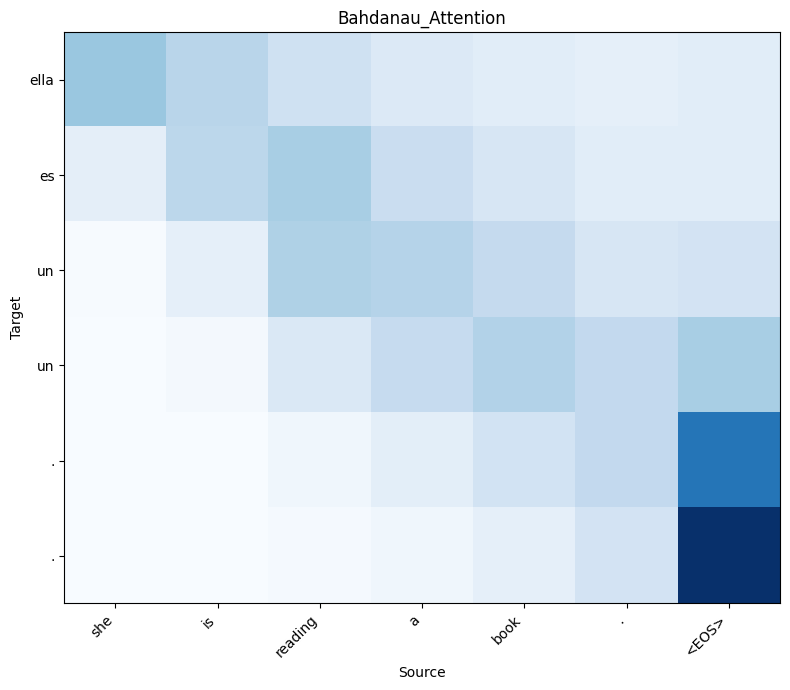

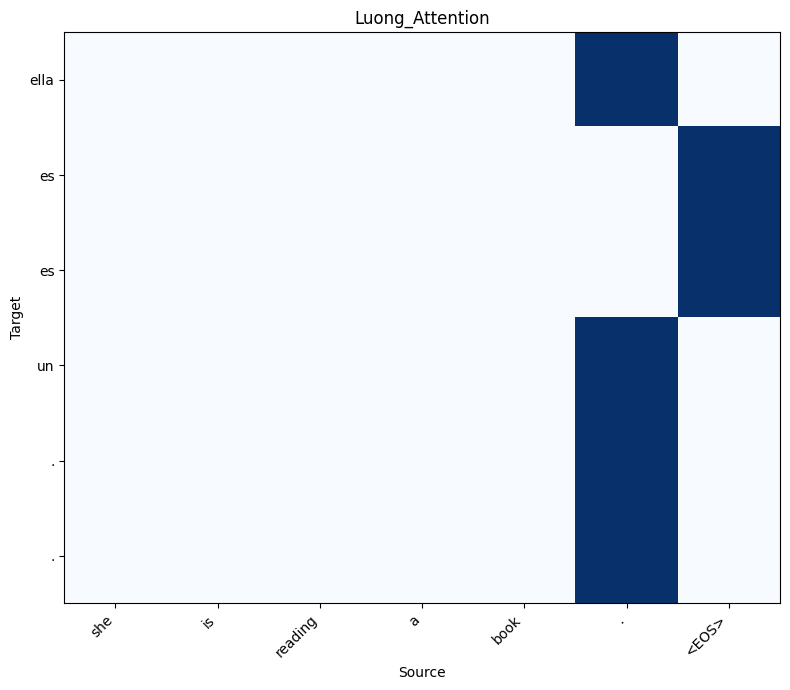

In [17]:
# Cell 17: Attention heatmap visualization
import numpy as np

def plot_attention(src_sent, translation, attns, title):
    if not attns: print('No attention weights available'); return
    src_tok = normalize(src_sent).split() + ['<EOS>']
    tgt_tok = translation.split()
    mat = np.array(attns)          # (tgt_len, src_len)
    fig, ax = plt.subplots(figsize=(len(src_tok)+1, len(tgt_tok)+1))
    ax.imshow(mat, cmap='Blues', aspect='auto')
    ax.set_xticks(range(len(src_tok))); ax.set_xticklabels(src_tok, rotation=45, ha='right')
    ax.set_yticks(range(len(tgt_tok))); ax.set_yticklabels(tgt_tok)
    ax.set_xlabel('Source'); ax.set_ylabel('Target'); ax.set_title(title)
    plt.tight_layout(); plt.savefig(f'{title}.png', dpi=150); plt.show()

sent = 'She is reading a book.'
t_bah, w_bah = translate(model_bah, sent)
t_luo, w_luo = translate(model_luo, sent)
plot_attention(sent, t_bah, w_bah, 'Bahdanau_Attention')
plot_attention(sent, t_luo, w_luo, 'Luong_Attention')

In [18]:
# Cell 18: Summary table
import pandas as pd
df = pd.DataFrame({
    'Model'      : ['No Attention', 'Bahdanau', 'Luong'],
    'Best ValLoss': [min(vl_noa), min(vl_bah), min(vl_luo)],
    'Best PPL'   : [math.exp(min(vl_noa)), math.exp(min(vl_bah)), math.exp(min(vl_luo))],
    'BLEU'       : [bleu_noa, bleu_bah, bleu_luo]
}).round(4)
print(df.to_string(index=False))

       Model  Best ValLoss  Best PPL    BLEU
No Attention        5.7081  301.2855 37.9918
    Bahdanau        5.1297  168.9608 22.7497
       Luong        5.2224  185.3737 21.7360
